# Notebook :  Ising Phases using Neural Networks in PyTorch 

This notebook is rewritten from https://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB14_CX-CNN-ising-Pytorch.html

Plaese check the version of your numpy, torch and python. My python is 3.10.2, numpy is 1.24.4, torch is 2.1.0. Difference of versions may result in unexpected problems that you may solve yourself. 

In [223]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
from torchvision import datasets # load data
from torch import from_numpy
import torch.nn as nn # construct NN
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc
import main
# fix seed for reproducibility
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

### Step 1: Load and Process the Ising Dataset

We start by defining the dataset class for Pytorch.

The Ising dataset is sampled by Monte Calo at different temperatures. Except near critical temperature, training data at all other temperature is mixed randomly. Test data is arranged according to temperature. And we should process data to input them. 

In [224]:
class Ising_Dataset(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, data_type, transform=False,temperature=0):
        """
        Args:
            data_type (string): `train` or `test': creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.
            temperature: temperature of the data
        """

        from sklearn.model_selection import train_test_split
        import collections
        import pickle as pickle
        # load data
        file_format_X='data/Ising2DFM_train_X_{:.2f}.pkl'
        file_format_Y='data/Ising2DFM_train_Y_{:.2f}.pkl'
        T=np.linspace(1.2,3.3,36)#temperature interval of 0.075
        for t in T:
            file_name_X=file_format_X.format(t)
            file_name_Y=file_format_Y.format(t)
            X_temp=pickle.load(open(file_name_X,'rb'))
            Y_temp=pickle.load(open(file_name_Y,'rb'))
            X_train, X_test, Y_train, Y_test = train_test_split(X_temp, Y_temp, train_size=0.8, test_size=0.2,random_state=seed)
            if(data_type=='train' and (t<2.0 or t>2.5)):#Do not use data near critical temperature to train
                if(abs(t-T[0])<0.001):
                    X=np.copy(X_train)
                    Y=np.copy(Y_train)
                else:
                    X=np.concatenate((X,X_train))
                    Y=np.concatenate((Y,Y_train))
            elif(data_type=='test' and np.abs(temperature-t)<0.001):
                X=np.copy(X_test)
                Y=np.copy(Y_test)
        X,X_none,Y,Y_none=train_test_split(X, Y, train_size=0.999, test_size=0.001,random_state=seed)#need to correct
        #np.random.shuffle(X.T)
        X=X.astype('float64')
        Y=Y.astype('float64')#convert to float64 to avoid some problems
        #print('X,Y:',X.shape,Y.shape)
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        #print( np.shape(self.data[1]))
        return np.shape(self.data[1])[0]

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

    
def load_data(kwargs,T):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    train_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='train',temperature=T),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='test',temperature=T),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

We then define the architecture of the neural net in the `model` class which contains the `forward` function method that tells us how to produce the output given some input. The backpropagaiton algorithm is implemented automatically by the Pytorch package.

Here we use a hidden layer of 100 neurons, and the activation is sigmoid. 

In [225]:
class model(nn.Module):
    # create nuerual network model
    def __init__(self):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        self.fc1 = nn.Linear(1600, 100)#input layer to hiddden layer
        self.fc2 = nn.Linear(100, 2)# hidden layer to output layer

    def forward(self, x):
        x=F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)
        return x

#### Define the `train` and `test` functions

These are very standard functions for going over data to train and evaluate the model. 

Since we will be testing the CNN performance on both the test and the critical data, the `test` function accepts two arguments: `data_loader` and `verbose` to allow control over the input data and the printing messages.

In [226]:
def train(epoch):
    # these are very standard functions for going over data to train

    DNN.train() # effects Dropout and BatchNorm layers, set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = DNN(data.float())
        #print(output.shape)
        #print(target.shape)
        loss = F.nll_loss(output, target.long())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader,verbose='Test'):
    # these are very standard functions for evaluating data
    import numpy as np
    DNN.eval() # effects Dropout and BatchNorm layers，set the model to testing mode
    test_loss = 0
    correct = 0
    last_layer_outputs = np.array([0.0,0.0]) 
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = DNN(data.float())
        test_loss += F.nll_loss(output, target.long(), size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()#sum up all correct predictions
        
        temp=output.detach().numpy()
        temp=np.exp(temp)
        temp=np.mean(temp,axis=0)#Do not reverse the order
        last_layer_outputs=np.vstack((last_layer_outputs,temp))
        

    test_loss /= len(data_loader.dataset)
    print('\n'+verbose+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    accuracy=100. * correct / len(data_loader.dataset)
    
    last_layer_outputs = last_layer_outputs[1:, :]
    last_layer_avg = np.mean(last_layer_outputs, axis=0)
    return accuracy, last_layer_avg

#### Define Model Parameters

Next we define the training settings. Now we also show how to turn on the `cuda` library option of PyTorch which enables parallel coputations (whenever resources for this are available). 

In [227]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=100, metavar='N',
                    help='input batch size for testing (default: 100)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model.

In [228]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

#set the work path
current_dir = os.getcwd()

os.chdir(current_dir)

updated_dir = os.getcwd()
print("Updated working directory:", updated_dir)



# load data
train_loader, test_loader=load_data(cuda_kwargs,1.20)

#build the model
DNN = model()
if args.cuda:
    DNN.cuda()

# negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
criterion = F.nll_loss
# define SGD optimizer
optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
#optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

# train the CNN and test its performance at each epoch
for epoch in range(1, args.epochs + 1):
    train(epoch)

#test for every T
T=np.linspace(1.2,3.3,36)
last_layer_avg=np.zeros((36,2))
all_accuracy=np.zeros(36)
for t in T:
    print('Temperature: ',t)
    train_loader, test_loader=load_data(cuda_kwargs,t)
    accuracy,avg=test(test_loader,verbose='Test')
    last_layer_avg[round((t-1.2)/0.06),:]=avg
    all_accuracy[round((t-1.2)/0.06)]=accuracy

print(last_layer_avg)

Updated working directory: c:\Users\WE\Desktop\机器学习学习
Train Epoch: 1 [0/111888 (0%)]	Loss: 0.921417
Train Epoch: 1 [640/111888 (1%)]	Loss: 0.302750
Train Epoch: 1 [1280/111888 (1%)]	Loss: 0.227216
Train Epoch: 1 [1920/111888 (2%)]	Loss: 0.222321
Train Epoch: 1 [2560/111888 (2%)]	Loss: 0.165757
Train Epoch: 1 [3200/111888 (3%)]	Loss: 0.166719
Train Epoch: 1 [3840/111888 (3%)]	Loss: 0.108357
Train Epoch: 1 [4480/111888 (4%)]	Loss: 0.113136
Train Epoch: 1 [5120/111888 (5%)]	Loss: 0.083062
Train Epoch: 1 [5760/111888 (5%)]	Loss: 0.111489
Train Epoch: 1 [6400/111888 (6%)]	Loss: 0.087358
Train Epoch: 1 [7040/111888 (6%)]	Loss: 0.083386
Train Epoch: 1 [7680/111888 (7%)]	Loss: 0.057409
Train Epoch: 1 [8320/111888 (7%)]	Loss: 0.067157
Train Epoch: 1 [8960/111888 (8%)]	Loss: 0.061452
Train Epoch: 1 [9600/111888 (9%)]	Loss: 0.073161
Train Epoch: 1 [10240/111888 (9%)]	Loss: 0.057269
Train Epoch: 1 [10880/111888 (10%)]	Loss: 0.053987
Train Epoch: 1 [11520/111888 (10%)]	Loss: 0.039718
Train Epoch: 1

c:\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.26

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.3199999999999998

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.38

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.44

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.5

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.5599999999999998

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.6199999999999999

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.68

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.7399999999999998

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.7999999999999998

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)

Temperature:  1.8599999999999999

Test set: Average loss: 0.0000, Accuracy: 999/999 (100%)



## Test for traingle Ising model

In [230]:
class Ising_Dataset_Triangle(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, transform=False,temperature=0):
        """
        Args:
            data_type (string): `train`, `test` or `critical`: creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """

        from sklearn.model_selection import train_test_split
        import collections
        import pickle as pickle
        # load data
        file_format_X='data/Ising2DFM_train_X_triangle{:.2f}.pkl'
        file_format_Y='data/Ising2DFM_train_Y_triangle{:.2f}.pkl'
        file_name_X=file_format_X.format(temperature)
        file_name_Y=file_format_Y.format(temperature)
        X=pickle.load(open(file_name_X,'rb'))
        Y=pickle.load(open(file_name_Y,'rb'))
        if(temperature<3.65):
            Y=0*Y#because I made a mistake when producing the data
        X=X.astype('float64')
        Y=Y.astype('float64')
        #print('X,Y:',X.shape,Y.shape)
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        #print( np.shape(self.data[1]))
        return np.shape(self.data[1])[0]

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

    
def load_data_triangle(kwargs,T):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset_Triangle(temperature=T),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

T=np.linspace(2.5,4.5,41)
tri_last_layer_avg=np.zeros((41,2))
tri_all_accuracy=np.zeros(41)
for t in T:
    print('Temperature: ',t)
    train_loader, test_loader=load_data_triangle(cuda_kwargs,t)
    accuracy,avg=test(test_loader,verbose='Test')
    #print(avg_out)
    #print(avg_out)
    tri_last_layer_avg[round((t-2.5)/0.05),:]=avg
    tri_all_accuracy[round((t-2.5)/0.05)]=accuracy


print(tri_last_layer_avg)


Temperature:  2.5

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.55

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.6

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.65

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.7

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.75

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.8

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.85

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.9

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  2.95


c:\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.0

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.05

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.1

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.15

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.2

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.25

Test set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)

Temperature:  3.3

Test set: Average loss: 0.0001, Accuracy: 1000/1000 (100%)

Temperature:  3.35

Test set: Average loss: 0.0087, Accuracy: 998/1000 (100%)

Temperature:  3.4

Test set: Average loss: 0.0025, Accuracy: 998/1000 (100%)

Temperature:  3.45

Test set: Average loss: 0.0104, Accuracy: 997/1000 (100%)

Temperature:  3.5

Test set: Average loss: 0.0357, Accuracy: 991/1000 (99%)

Temperature:  3.55

Test set: Average loss: 0.1021, Accuracy: 976/1000

## Plot data

The critical temperature is determined by human intellengence.

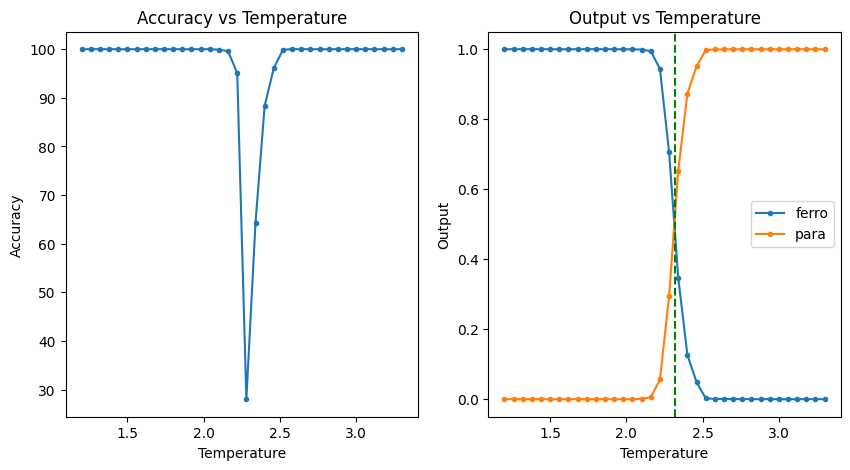

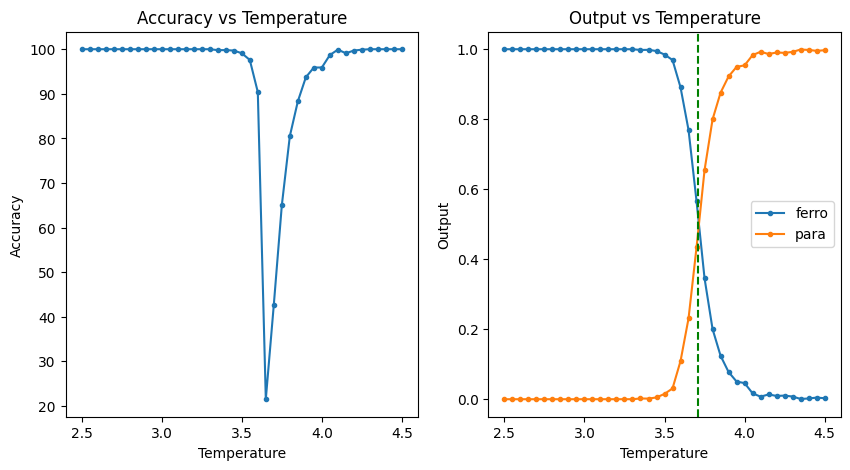

In [231]:
def plot_results(accuracy, last_layer_avg, T, critical_temperature):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(T, accuracy, 'o-',markersize=3)
    
    plt.xlabel('Temperature')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Temperature')
    plt.subplot(1, 2, 2)
    plt.plot(T, last_layer_avg[:, 0], 'o-', label='ferro',markersize=3)
    plt.plot(T, last_layer_avg[:, 1], 'o-', label='para',markersize=3)
    plt.axvline(x=critical_temperature, color='green', linestyle='--')
    plt.xlabel('Temperature')
    plt.ylabel('Output')
    plt.title('Output vs Temperature')
    plt.legend()
    plt.show()

T=np.linspace(1.2,3.3,36)
plot_results(all_accuracy, last_layer_avg,T,2.32)
T=np.linspace(2.5,4.5,41)
plot_results(tri_all_accuracy, tri_last_layer_avg,T,3.71)